In [1]:
#Импорт всего

# Currently %tensorflow_version 2.x installs beta1, which doesn't work here.
# %tensorflow_version can likely be used after 2.0rc0  
#!pip install tf-nightly-gpu-2.0-preview
#!pip install tf-nightly-gpu-2.0-preview
from __future__ import absolute_import, division, print_function, unicode_literals

# Install TensorFlow

import tensorflow as tf

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time
%matplotlib inline

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

The following GPU devices are available: /device:GPU:0


In [2]:
from google.colab import files

In [3]:
import cv2 as cv


Загрузим картинку

In [4]:
files.upload()

Saving 00_000200.png to 00_000200.png
Saving 00_000600.png to 00_000600.png
Saving dsc_0413_27446706543_o.jpg to dsc_0413_27446706543_o.jpg
Saving haarcascade_eye.xml to haarcascade_eye.xml
Saving haarcascade_frontalface_default.xml to haarcascade_frontalface_default.xml


## OpenCV - Selectiv Search

https://www.pyimagesearch.com/2020/06/29/opencv-selective-search-for-object-detection/

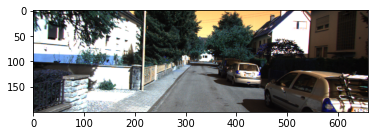

In [21]:
#Читаем картинку
im = cv.imread('/content/00_000600.png')
    
# размеры изображения
newH = 200  #высота
newW = int(im.shape[1]*200/im.shape[0]) # ширина 
#сжатая картинка
im = cv.resize(im, (newW, newH)) 
#Выводим 

plt.imshow(im)
plt.show()

Selective Search(селективный поиск)

In [22]:
#Настройка модели
cv.setUseOptimized(True) #режим оптимизации
cv.setNumThreads(6)      #количество потоков

In [23]:
# Объект Selective Search Segmentation
sss = cv.ximgproc.segmentation.createSelectiveSearchSegmentation()

# запускаем с картинкой
sss.setBaseImage(im)
  
# Выбираем точный метод 
sss.switchToSelectiveSearchQuality()

# Делаем selective search segmentation 
rects = sss.process() 
#вернёт массив прямоугольников, где возможно что-то есть
print(rects.shape) #число найденых объектов

(6380, 4)


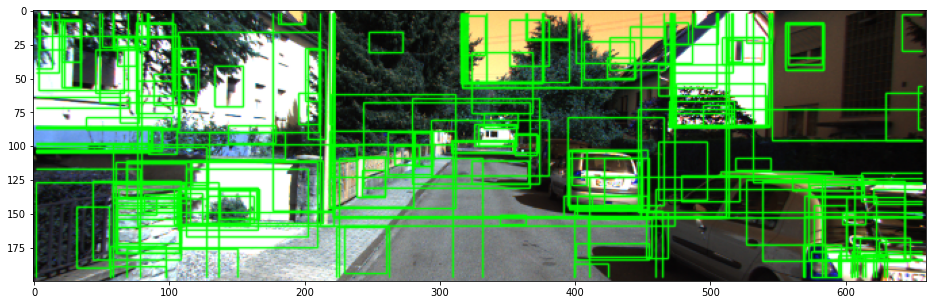

In [25]:
#Построим области

num_Rects = 200 #число выводимых region proposals (прямоугольников)

#создаем копию исходной картинки
im_ = im.copy()

for i, rect in enumerate(rects): 
    if (i < num_Rects): #пока не больше 
        # x,y - координаты левого верхнего угла; w, h - ширина и высота области
        x, y, w, h = rect
        # рисуем рамку      
        cv.rectangle(im_, (x, y), (x+w, y+h), (0, 255, 0), 1, cv.LINE_AA) 
    else: 
        break 

# Рисуем на экран
plt.figure(figsize=(16,5))
plt.imshow(im_) 
plt.show()

https://github.com/opencv/opencv/tree/master/data/haarcascades

Запишем маршрут, где есть что-нибудь для чтения (последовательность из нескольких фотографий )



In [ ]:
root_path = './' #change dir to your project folder 

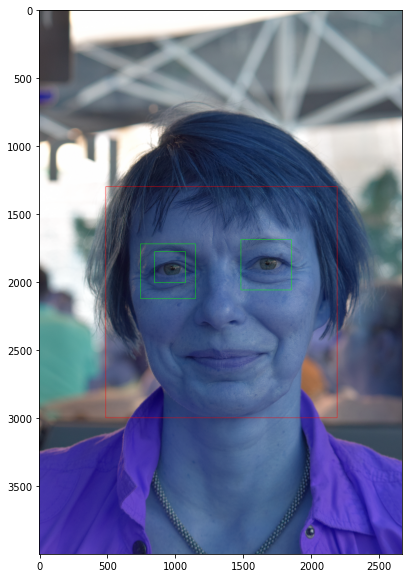

In [26]:
imf = cv.imread('/content/dsc_0413_27446706543_o.jpg')

#https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_frontalface_default.xml
face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')
#https://github.com/Itseez/opencv/blob/master/data/haarcascades/haarcascade_eye.xml
eye_cascade = cv.CascadeClassifier('haarcascade_eye.xml')


gray = cv.cvtColor(imf, cv.COLOR_RGB2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)


for (x,y,w,h) in faces:
    cv.rectangle(imf,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = imf[y:y+h, x:x+w]

    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)
plt.figure(figsize=(10,10))
plt.imshow(imf)      
plt.show()   

## **Формирование и обработка результатов детектирования**


Запишем основные функции из примера TensorFlow (https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb) и адаптируем их для своих целей

In [28]:
# выводит картинку
def display_image(image):
    fig = plt.figure(figsize=(20, 15))
    plt.grid(False)
    plt.imshow(image)

#  Грузим и обрабатываем картинку
def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
    _, filename = tempfile.mkstemp(suffix=".jpg")
    response = urlopen(url)
    image_data = response.read()
    #read image
    image_data = BytesIO(image_data)
    pil_image = Image.open(image_data)
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    pil_image_rgb = pil_image.convert("RGB")
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    #print("Image downloaded to %s." % filename)
    if display:
        display_image(pil_image)
    return filename

#  Рисуем рамку на изображении
def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
    """Adds a bounding box to an image."""
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
  # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                        (left + text_width, text_bottom)],
                       fill=color)
        draw.text((left + margin, text_bottom - text_height - margin),
                  display_str,
                  fill="black",
                  font=font)
        text_bottom -= text_height - 2 * margin

#  Рисуем все рамки
# max_boxes - максимальное число объектов для отображения, min_score=0.01 - минимакльная точность их детекции
# можно менять

def draw_boxes(image, boxes, class_names, scores, max_boxes=3, min_score=0.01):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    colors = list(ImageColor.colormap.values())

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
    except IOError:
        print("Font not found, using default font.")
        font = ImageFont.load_default()

    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])
            display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                         int(100 * scores[i]))
            color = colors[hash(class_names[i]) % len(colors)]
            image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
            draw_bounding_box_on_image(
              image_pil,
              ymin,
              xmin,
              ymax,
              xmax,
              color,
              font,
              display_str_list=[display_str])
            np.copyto(image, np.array(image_pil))
    return image

Загрузка детектора

In [43]:
module_handle = "https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Формируем тензор

In [30]:
def load_img(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img

Выполняем детектор

In [32]:
def run_detector(detector, path):
    img = load_img(path)

    converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
    start_time = time.time()
    result = detector(converted_img)
    end_time = time.time()
    #print(result['detection_scores'])
    result = {key:value.numpy() for key,value in result.items()} 

    image_with_boxes = draw_boxes(
      img.numpy(), result["detection_boxes"],
      result["detection_class_entities"], result["detection_scores"], max_boxes=100)

    display_image(image_with_boxes)
    return result

Возвращаем рамки для объектов

In [33]:
#  Найдем рамку
# max_boxes - максимальное число объектов для отображения, min_score=0.0 - минимакльная точность их детекции
# можно менять
def get_bounding_box_on_image(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""
    if len(image.shape)>3:
    image=image.reshape(image.shape[-3],image.shape[-2],image.shape[-1])
    I_shape=np.uint8(image).shape
    #print(I_shape)
    im_array=[]
    for i in range(min(boxes.shape[0], max_boxes)): 
        #print(tuple(boxes[i]))
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])


            yminI = np.int(ymin*I_shape[0])
            ymaxI = np.int(ymax*I_shape[0])
            xminI = np.int(xmin*I_shape[1])
            xmaxI = np.int(xmax*I_shape[1])
            imf = np.array(image)[yminI:ymaxI,xminI:xmaxI,:]
            #print(imf.shape,imf[0,0,:])
            im_array.append(imf.copy())  

    return im_array

In [34]:
#  Вернем рамки
def get_boxes(image, boxes, class_names, scores, max_boxes=100, min_score=0.1):
    """Overlay labeled boxes on an image with formatted scores and label names."""

    image_pil = np.array(image)
    for i in range(min(boxes.shape[0], max_boxes)):
        if scores[i] >= min_score:
            ymin, xmin, ymax, xmax = tuple(boxes[i])

            imf= get_bounding_box_on_image(image_pil, boxes, class_names, scores, max_boxes=max_boxes, min_score=0.1)
     
    return imf

Чтение имен кадров 

In [35]:
import os, fnmatch
listOfFiles = os.listdir(root_path)
pattern = '*.png'
List_name=[]
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            List_name.append(np.array(root_path+entry))
List_name[0]

array('./00_000200.png', dtype='<U15')

In [36]:
List_name[1]

array('./00_000600.png', dtype='<U15')

Проверяем детектор

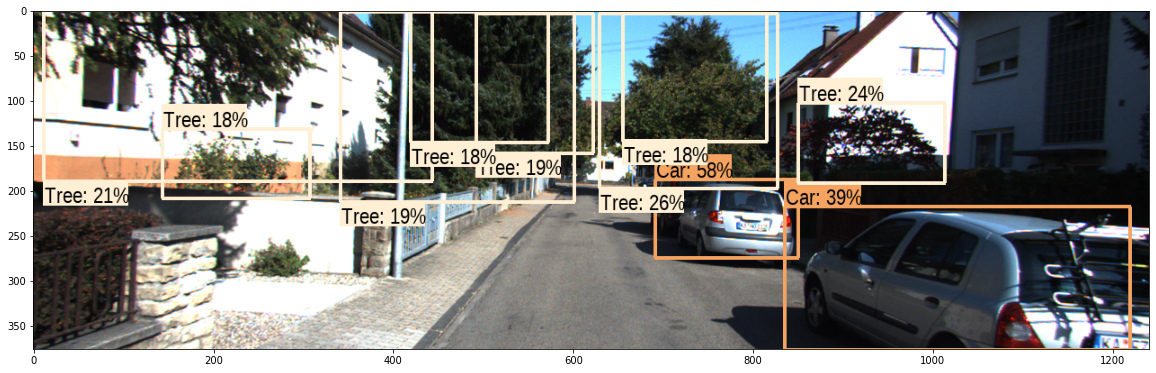

In [44]:
result = run_detector(detector, List_name[1])

In [42]:
result

{'detection_boxes': array([[5.77792943e-01, 6.82151318e-01, 9.91924226e-01, 9.91847038e-01],
        [5.04018068e-01, 5.78675687e-01, 7.47528732e-01, 6.81975901e-01],
        [4.68260884e-01, 5.48883975e-01, 6.54567540e-01, 6.19033396e-01],
        [2.05746312e-02, 5.13937056e-01, 5.33463597e-01, 6.62762821e-01],
        [1.97193027e-02, 3.07883710e-01, 5.49466431e-01, 5.04536271e-01],
        [0.00000000e+00, 1.49096698e-02, 5.75433969e-01, 3.33791077e-01],
        [9.28530563e-03, 1.86236203e-03, 3.74645650e-01, 2.89459765e-01],
        [7.92361259e-01, 6.91214919e-01, 9.52083945e-01, 7.14088559e-01],
        [2.49332428e-01, 6.64989948e-01, 4.91636515e-01, 8.14136982e-01],
        [1.51692294e-02, 6.44295573e-01, 5.21518707e-01, 8.33176732e-01],
        [6.52586579e-01, 5.91836214e-01, 7.40102589e-01, 6.04923725e-01],
        [3.73046041e-01, 1.27601147e-01, 5.49018562e-01, 2.25930929e-01],
        [3.40627640e-01, 2.58077145e-01, 5.51562369e-01, 3.07407975e-01],
        [1.42294168

Object Detection API TensorFlow (2.)
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_training_and_evaluation.md
____________________________________________
**Настройка Object Detection API**(Googl Colaboratory)

!apt-get install protobuf-compiler python-pil python-lxml python-tk 

!pip install Cython 

!git clone https://github.com/tensorflow/models.git 

%cd /content/models/research !protoc object_detection/protos/*.proto --python_out=. 

%set_env PYTHONPATH=/content/models/research:/content/models/research/slim 

!python object_detection/builders/model_builder_test.py


или model_builder_tf2_test.py для TF2


Пример простой настройки модели в колабе (родной от TF, займет 10-15 на запуск): https://github.com/tensorflow/models/blob/master/research/object_detection/colab_tutorials/eager_few_shot_od_training_tf2_colab.ipynb

___________________________________________
**Настройка Object Detection API**(Win)

Перед тем, как начать настраивать Object Detection API, нужно удостовериться, что на компьютере установлен Git Bash. Git Bash – набор инструментов для простого взаимодействия с веб-сервисом для хостинга IT-проектов GitHub. 

Для начала работы с TensorFlow Object Detection API необходимо
«клонировать» репозиторий tensorflow/models на текущую машину. Для этого нужно воспользоваться командой 

git clone https://github.com/tensorflow/models.git


Чтобы Object Detection API работал, необходимо скомпилировать его буферы протоколов. Они служат как бинарная альтернатива текстовому формату XML, но являются более простыми, компактными и быстрыми в связи с тем, что осуществляется передача оптимизированных бинарных данных. Для этого нужно скачать и установить protoc-3.4.0-win32.zip из официального репозитория protocol buffers. 

После этого, перейдя в папку models, достаточно выполнить следующую команду в командном окне: 
"C:/Program Files/protoc/bin/protoc" object_detection/protos/*.proto --python_out=.

Помимо этого, для того, чтобы в будущем была возможна тонкая настройка, необходимо создать системную переменную среды PYTHONPATH и поместить туда следующие пути к папкам:

<Путь к репозиторию tensorflow models>\models\research\object_detection;

<Путь к репозиторию tensorflow models>\models\research\slim;

<Путь к репозиторию tensorflow models>\models\research;
Теперь можно приступать к работе с API.

